In [1]:
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.stats import multivariate_normal, mode, norm
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, completeness_score, homogeneity_score, confusion_matrix, confusion_matrix, classification_report
import seaborn as sns
sns.palplot(sns.color_palette("Blues"))
import pandas as pd

In [3]:
import data

x_train, x_test, y_train, y_test = data.load_sk_digits()

x_train /= 16
x_test /= 16

print(x_train.mean(axis=0).max())
print(x_train.var(axis=0).max())

0.7601929196499603
0.16588529256054566


0
delta mean -inf
delta cov -inf


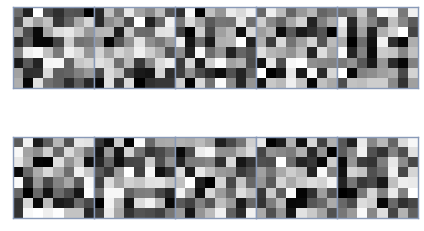

10
delta mean 0.04015821732161867
delta cov 0.01524146411076692


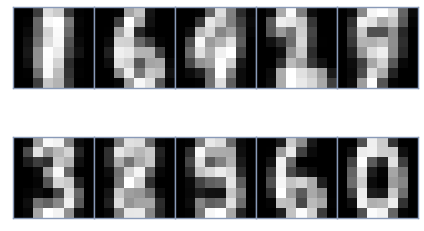

20
delta mean 0.003990019503344433
delta cov 0.0023667399170956838


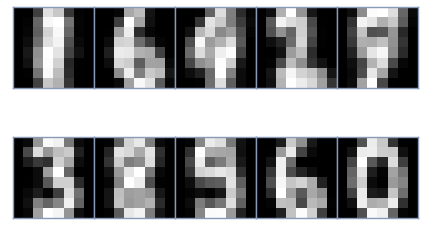

30
delta mean 0.000891811223241723
delta cov 0.0004963793510858738


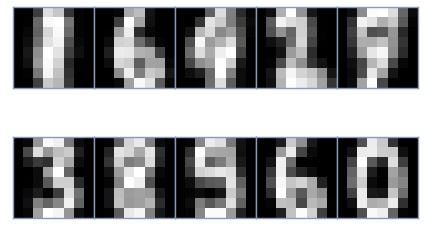

40
delta mean 2.148505355026309e-05
delta cov 6.925692942361117e-06


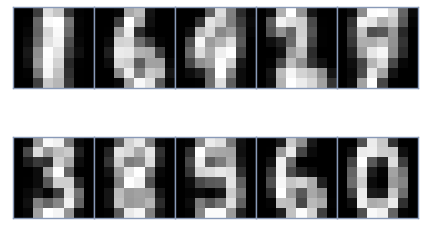

50
delta mean 1.5683063995242108e-06
delta cov 7.097748216944311e-07


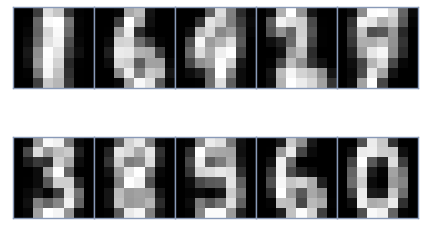

60
delta mean 1.5183193013967866e-07
delta cov 9.248040111486944e-08


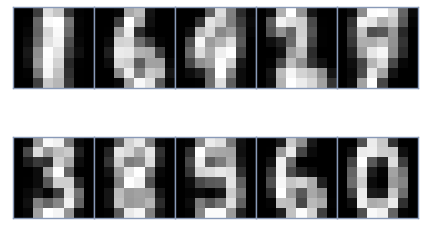

70
delta mean 1.8995172657021442e-08
delta cov 1.1586509862659966e-08


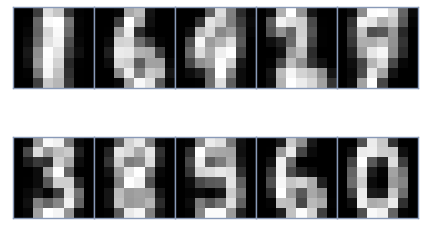

converged


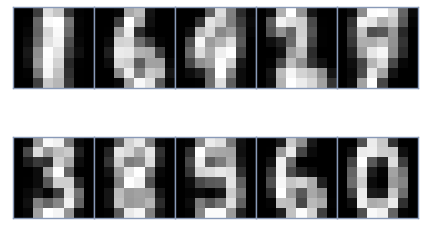

In [4]:
class GMM:
    def __init__(self, k, tol=1e-8, max_iter=100):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
    
    def plot(self, means, covs, weights):
        
        fig, ax = plt.subplots(2, 5, subplot_kw=dict(xticks=[], yticks=[]), gridspec_kw={'hspace': 0, 'wspace': 0})
        fig.tight_layout()
        for i, axi in enumerate(ax.flat):
            im = axi.imshow(np.reshape(means[i], (8,8)), cmap=plt.cm.gray)
        plt.show()
        

    def fit(self, x, plot=True):
        
        means = np.random.uniform(0, np.ceil(x.mean(axis=0).max()), size=(self.k,x[0].shape[0]))
        covs = np.random.uniform(0.01, np.ceil(x.var(axis=0).max()), size=(self.k, x[0].shape[0]))
        weights = np.full(self.k, 1/self.k)
        delta_mean = -np.inf
        delta_cov = -np.inf

        for _ in range(self.max_iter):

            if _ % 10 == 0:
#               clear_output(wait=True)
                print(_)
                print('delta mean', delta_mean)
                print('delta cov', delta_cov)
                if plot:
                    self.plot(means, covs, weights)

            r = np.zeros((len(x), self.k))

            for i, xi in enumerate(x):
                num = weights * np.prod([norm.pdf(xi, means[k], np.sqrt(covs[k])) for k in range(self.k)], axis = 1)
                r[i,:] = num/np.sum(num)

            rk = r.sum(axis=0)
            weights = rk/len(x)

            delta_mean = -np.inf
            delta_cov = -np.inf
            for k in range(self.k):
                mean = np.sum([r[i,k]*xi for i, xi in enumerate(x)], axis=0)/np.sum(rk[k])
                delta_mean = np.maximum(delta_mean, np.abs(means[k] - mean).max())
                means[k] = mean

                cov = np.sum([r[i,k]*xi**2 for i, xi in enumerate(x)], axis=0)/np.sum(rk[k]) - mean**2 + 1e-2
                delta_cov = np.maximum(delta_cov, np.abs(covs[k] - cov).max())
                covs[k] = cov


            if(delta_mean < self.tol and delta_cov < self.tol):
                print('converged')
                self.plot(means, covs, weights)
                break

        self.weights_ = weights
        self.means_ = means
        self.covariances_ = covs

    
t = GMM(10, max_iter=200, tol=1e-8)
t.fit(x_train)

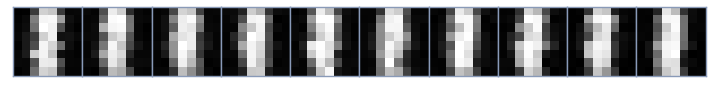

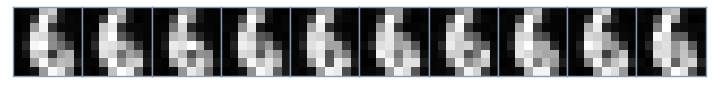

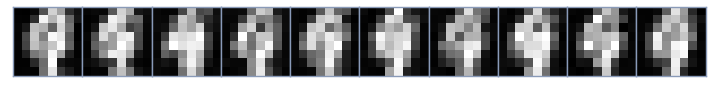

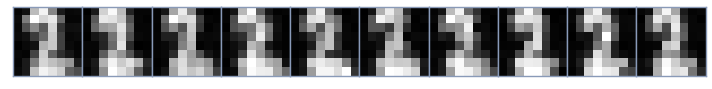

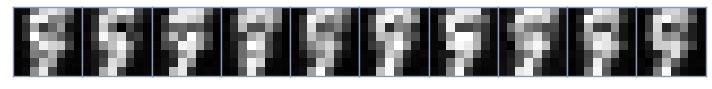

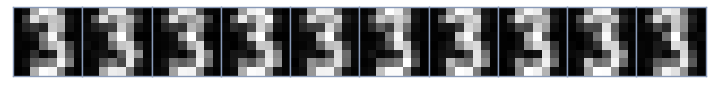

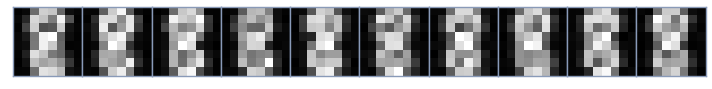

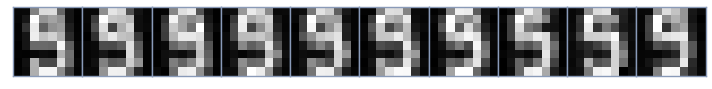

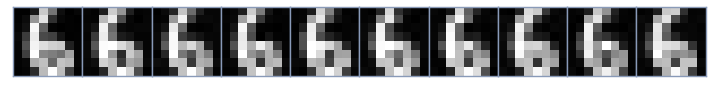

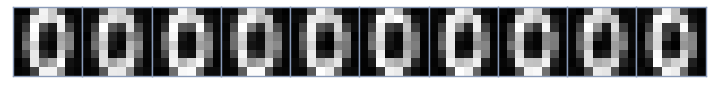

In [5]:
# Generating numbers using the learnt distributions
for i in range(10):
    fig, ax = plt.subplots(1, 10, figsize=(10,10),  subplot_kw=dict(xticks=[], yticks=[]), gridspec_kw={'hspace': 0, 'wspace': 0})
    fig.tight_layout()
    for j, axi in enumerate(ax.flat):
        pixels = np.array([np.random.normal(t.means_[i][pixel], t.covariances_[i][pixel]) for pixel in range(64)])
        im = axi.imshow(np.reshape(pixels, (8,8)), cmap=plt.cm.gray)
    plt.show()

In [6]:
gmm = GaussianMixture(10, covariance_type='diag', init_params='random')
gmm.fit(x_train)
print(gmm.converged_)

True


In [7]:
# for i in range(10):
#     for j in range(10):
#         pixels = np.array([np.random.normal(gmm.means_[i][pixel], gmm.covariances_[i][pixel]) for pixel in range(64)])
#         plt.subplot(2, 5, j + 1)
#         plt.imshow(pixels.reshape(8,8), cmap=plt.cm.gray)
#     plt.show()

In [8]:
# (t.covariances_.sum(),np.array([np.diagonal(cov) for cov in gmm.covariances_]).sum()),(
# t.means_.sum(),gmm.means_.sum())
(t.covariances_.sum(),gmm.covariances_.sum()),(
t.means_.sum(),gmm.means_.sum())

((31.568585231406857, 29.351850408747815),
 (196.45549974667506, 195.97411549228696))

In [9]:

class GNB:
    def __init__(self, gmm):
        self.gmm = gmm
        
    def fit(self, k, x_train, y_train):
        self.k = k
        
        self.mean = self.gmm.means_
        self.var = self.gmm.covariances_
        self.w = np.log(self.gmm.weights_)
            
        
        self.create_target_mapping(x_train, y_train)
        
    # TODO: Could try to resolve ties in a way that minimizes duplicate labels
    def create_target_mapping(self, x_train, y_train):
        self.target_mapping = np.zeros(self.k)
        y_pred = self.predict(x_train, translate_targets=False)
        for i in range(self.k):
            indexes = y_pred == i
            self.target_mapping[i] = mode(y_train[indexes])[0][0]
    
    def predict_single(self, x):
        f = lambda i: self.w[i] + multivariate_normal.logpdf(x, mean=self.mean[i], cov=self.var[i])
        
        return np.argmax(
            np.fromfunction(np.vectorize(f), shape=(self.k,), dtype=int)
        )
    
    def predict(self, x_test, translate_targets=True):
        y = np.apply_along_axis(self.predict_single, axis=1, arr=x_test)
        return self.target_mapping[y] if translate_targets else y

In [10]:
def print_metrics(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    targets = list(range(10))
    
    cm = confusion_matrix(y_test, y_pred, targets)
    cm_norm = cm / cm.sum(axis=1)
    
    cm_norm_df = pd.DataFrame(cm_norm, index=targets, columns=targets)
    
    plt.figure(figsize = (10,8))
    sns.set(font_scale=1.1)
    ax = sns.heatmap(
        cm_norm_df,
        annot=True,
        cmap="Blues",
    )

    font_styles = {'fontsize': 16, 'weight': 'bold'}

    ax.set_title('Confusion matrix', {**font_styles, 'fontsize': 25})
    ax.set_xlabel('Predicted', **font_styles)
    ax.set_ylabel('Actual', **font_styles)

    # matplotlib bug fix
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
    print('accuracy', accuracy_score(y_test, y_pred))
    print('completeness_score', completeness_score(y_test, y_pred))
    print('homogeneity_score', homogeneity_score(y_test, y_pred))

/home/kasper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      0.95      0.97        59
           1       0.80      0.41      0.54        49
           2       0.78      0.88      0.83        49
           3       0.98      0.75      0.85        64
           4       0.68      0.92      0.78        61
           5       0.00      0.00      0.00        47
           6       0.96      1.00      0.98        51
           7       0.55      0.91      0.68        57
           8       0.77      0.87      0.82        46
           9       0.62      0.79      0.69        57

    accuracy                           0.76       540
   macro avg       0.71      0.75      0.71       540
weighted avg       0.73      0.76      0.73       540



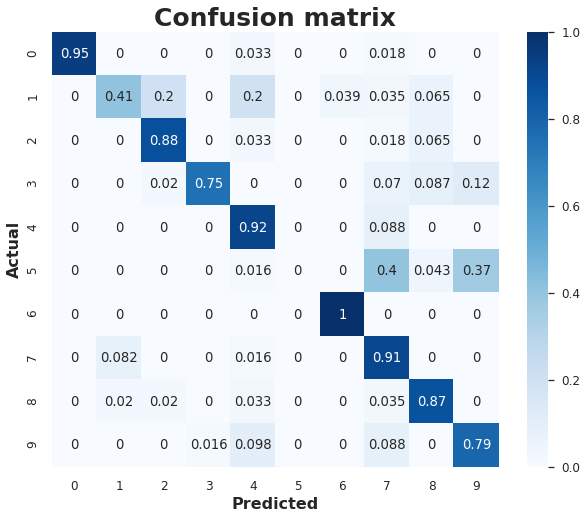

accuracy 0.7611111111111111
completeness_score 0.7304533964185917
homogeneity_score 0.6817696819694998


In [11]:
nb = GNB(t)
nb.fit(10, x_train, y_train)
y_pred = nb.predict(x_test)


print_metrics(y_test, y_pred)

/home/kasper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      0.85      0.92        59
           1       0.00      0.00      0.00        49
           2       0.77      0.82      0.79        49
           3       0.49      0.67      0.57        64
           4       1.00      0.74      0.85        61
           5       0.60      0.64      0.62        47
           6       0.89      0.98      0.93        51
           7       0.43      0.89      0.58        57
           8       0.30      0.54      0.39        46
           9       0.00      0.00      0.00        57

    accuracy                           0.62       540
   macro avg       0.55      0.61      0.57       540
weighted avg       0.56      0.62      0.57       540



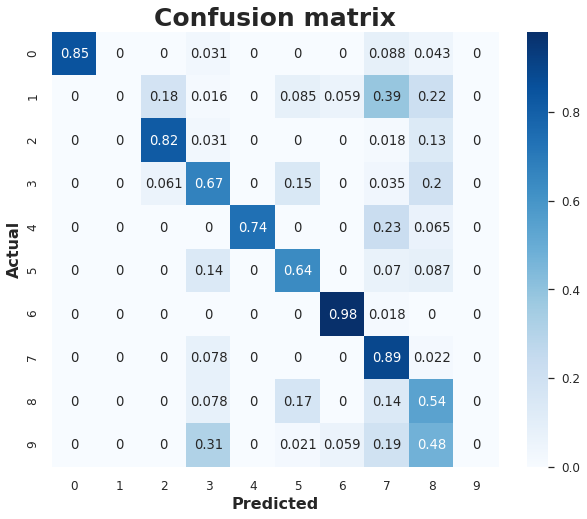

accuracy 0.6185185185185185
completeness_score 0.5899607105265797
homogeneity_score 0.5191666176766717


In [12]:
nb = GNB(gmm)
nb.fit(10, x_train, y_train)
y_pred = nb.predict(x_test)


print_metrics(y_test, y_pred)

/home/kasper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      0.90      0.95        59
           1       0.50      0.24      0.33        49
           2       0.72      0.80      0.76        49
           3       0.46      0.84      0.60        64
           4       0.95      0.89      0.92        61
           5       0.81      1.00      0.90        47
           6       0.94      1.00      0.97        51
           7       0.84      0.98      0.90        57
           8       0.45      0.54      0.49        46
           9       0.00      0.00      0.00        57

    accuracy                           0.72       540
   macro avg       0.67      0.72      0.68       540
weighted avg       0.67      0.72      0.68       540



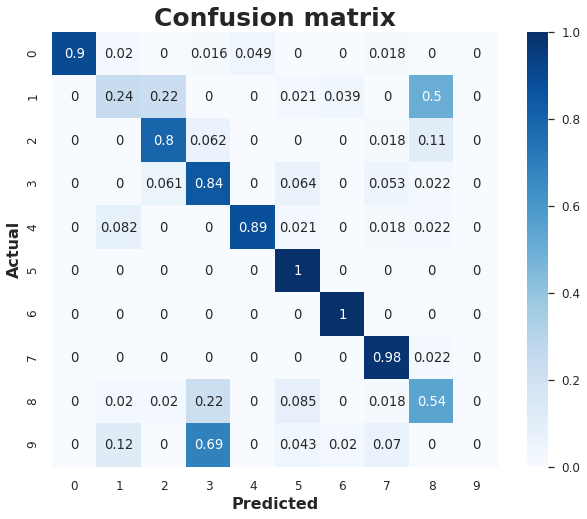

accuracy 0.7240740740740741
completeness_score 0.741468130129897
homogeneity_score 0.687434181190277


In [13]:
gmm2 = GaussianMixture(10, covariance_type='full', init_params='kmeans')
gmm2.fit(x_train)
gmm2.covariances_ = np.array([np.diagonal(cov) for cov in gmm2.covariances_])


nb = GNB(gmm2)
nb.fit(10, x_train, y_train)
y_pred = nb.predict(x_test)


print_metrics(y_test, y_pred)

In [14]:
x1 = np.random.normal(5, 1, 500)
x2 = np.random.normal(10, 2, 500) 

x = np.concatenate([x1,x2])


In [15]:
temp = GMM(2)
temp.fit(x.reshape(-1, 1), plot=False)

0
delta mean -inf
delta cov -inf
10
delta mean 0.07259858079662518
delta cov 0.06476404605510311
20
delta mean 0.13423193932872302
delta cov 0.2450052111955756
30
delta mean 0.056383720281218075
delta cov 0.1800713085217609
40
delta mean 0.013147145467184984
delta cov 0.03906950002297549
50
delta mean 0.0026878723118795023
delta cov 0.007731037426268017
60
delta mean 0.0005428311834734245
delta cov 0.0015499152611369027
70
delta mean 0.00010944353351405312
delta cov 0.0003120169953945151
80
delta mean 2.205882623762534e-05
delta cov 6.286921080800312e-05
90
delta mean 4.445785107165534e-06
delta cov 1.2670021263261333e-05


In [16]:
temp.weights_

array([0.49670937, 0.50329063])

In [17]:
temp.means_

array([[10.20244306],
       [ 5.08097129]])

In [18]:
temp.covariances_

array([[3.88729659],
       [1.01396053]])

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1).fit(x_train)

In [20]:
target_mapping = np.full(10, -1)
y_pred = kmeans.predict(x_train) 
for i in range(10):
    indexes = y_pred == i
    target_mapping[i] = mode(y_train[indexes])[0][0]

/home/kasper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        59
           1       0.49      0.76      0.59        49
           2       0.77      0.84      0.80        49
           3       0.67      0.80      0.73        64
           4       0.98      0.95      0.97        61
           5       0.90      0.81      0.85        47
           6       0.98      1.00      0.99        51
           7       0.83      0.93      0.88        57
           8       0.00      0.00      0.00        46
           9       0.76      0.79      0.78        57

    accuracy                           0.80       540
   macro avg       0.74      0.79      0.76       540
weighted avg       0.75      0.80      0.77       540



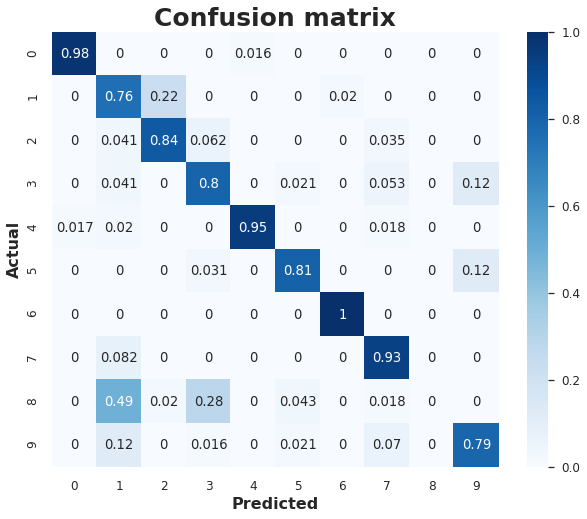

accuracy 0.8
completeness_score 0.7793590057629051
homogeneity_score 0.7406272346930519


In [21]:
y_pred = target_mapping[kmeans.predict(x_test)]

print_metrics(y_test, y_pred)